### Attention‑based Transformer model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, 
                             cohen_kappa_score, confusion_matrix)
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv('dataset.csv')

C:\Users\raksh\AppData\Local\Temp\ipykernel_9952\112859877.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


In [3]:
def get_engine_status(row):
    dtc = str(row['DTC_NUMBER']).strip() if pd.notnull(row['DTC_NUMBER']) else ""
    tc = str(row['TROUBLE_CODES']).strip() if pd.notnull(row['TROUBLE_CODES']) else ""
    # If DTC_NUMBER equals "MIL is OFF1" OR TROUBLE_CODES is nonblank and starts with "P"
    if dtc == "MIL is OFF1" or (tc != "" and tc.upper().startswith("P")):
        return 1  # malfunctioning
    else:
        return 0  # healthy

In [4]:
cols_to_drop = [
    'AUTOMATIC', 'BAROMETRIC_PRESSURE(KPA)', 'FUEL_LEVEL', 'AMBIENT_AIR_TEMP', 
    'INTAKE_MANIFOLD_PRESSURE', 'MAF', 'LONG TERM FUEL TRIM BANK 2', 'FUEL_TYPE', 
    'FUEL_PRESSURE', 'SHORT TERM FUEL TRIM BANK 2', 'ENGINE_RUNTIME', 
    'EQUIV_RATIO', 'TIMESTAMP', 'VEHICLE_ID'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)


In [5]:
feature_cols = [
    'MARK', 'MODEL', 'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 
    'ENGINE_LOAD', 'ENGINE_RPM', 'AIR_INTAKE_TEMP', 'SPEED', 
    'SHORT TERM FUEL TRIM BANK 1', 'THROTTLE_POS', 'TIMING_ADVANCE', 
    'MIN', 'HOURS', 'DAYS_OF_WEEK', 'MONTHS', 'YEAR'
]

In [6]:
df_model = df[ feature_cols + ['DTC_NUMBER', 'TROUBLE_CODES'] ].copy()
df_model['EngineStatus'] = df_model.apply(get_engine_status, axis=1)
df_model.dropna(subset=['EngineStatus'], inplace=True)

In [7]:
X = df_model[feature_cols]
y = df_model['EngineStatus'].values 
meta_info = df_model[['DTC_NUMBER', 'TROUBLE_CODES']]

In [9]:
# preprocessing pipeling
categorical_features = ['MARK', 'MODEL']
numeric_features = [col for col in feature_cols if col not in categorical_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [10]:
#splitting the data into training and testing
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X, y, meta_info, test_size=0.2, random_state=42
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

input_dim = X_train_processed.shape[1]

## Model Buidling

In [14]:
d_model = 32      # Embedding dimension for each token.
ff_dim = 64       # Hidden layer size in FFN.
num_heads = 4     # Number of attention heads.
dropout_rate = 0.1

# positional embedding layer .
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super().__init__()
        self.pos_emb = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length

    def call(self, x):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        embedded_positions = self.pos_emb(positions)
        return x + embedded_positions

#Transformer encoder block
def transformer_encoder(inputs, num_heads, ff_dim, dropout_rate):
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = tf.keras.layers.Dense(ff_dim, activation='relu')(out1)
    ffn_output = tf.keras.layers.Dense(d_model)(ffn_output)
    ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Transformer model
inputs = tf.keras.Input(shape=(input_dim,)) 
x = tf.keras.layers.Lambda(lambda t: tf.expand_dims(t, axis=-1))(inputs)
x = tf.keras.layers.Dense(d_model)(x) 
x = PositionalEmbedding(sequence_length=input_dim, embed_dim=d_model)(x)
x = transformer_encoder(x, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

transformer_model = tf.keras.models.Model(inputs, outputs, name="Transformer_Model")
transformer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
transformer_model.summary()


Model: "Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 38, 1)     │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 38, 32)    │         64 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 38, 32)    │      1,216 │ dense_5[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 38, 32)    │     16,800 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 38, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 38, 32)    │          0 │ positional_embed… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 38, 32)    │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 38, 64)    │      2,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 38, 32)    │      2,080 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 38, 32)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 38, 32)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 38, 32)    │         64 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      1,056 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,489 (91.75 KB)

 Trainable params: 23,489 (91.75 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_transformer = transformer_model.fit(
    X_train_processed, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9367 - loss: 0.1823 - val_accuracy: 0.9925 - val_loss: 0.0309
Epoch 2/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9945 - loss: 0.0249 - val_accuracy: 0.9862 - val_loss: 0.0319
Epoch 3/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9943 - loss: 0.0224 - val_accuracy: 0.9957 - val_loss: 0.0181
Epoch 4/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9960 - loss: 0.0180 - val_accuracy: 0.9959 - val_loss: 0.0166
Epoch 5/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9956 - loss: 0.0171 - val_accuracy: 0.9957 - val_loss: 0.0154
Epoch 6/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9944 - loss: 0.0204 - val_accuracy: 0.9961 - val_loss: 0.0144
Epoch 7/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9956 - loss: 0.0157 - val_accuracy: 0.9958 - val_loss: 0.0194
Epoch 8/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9958 - loss: 0.0138 - val_accuracy

### evaluation of the model

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9959 - loss: 0.0149
Transformer Model Test Loss: 0.0152, Test Accuracy: 0.9963
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


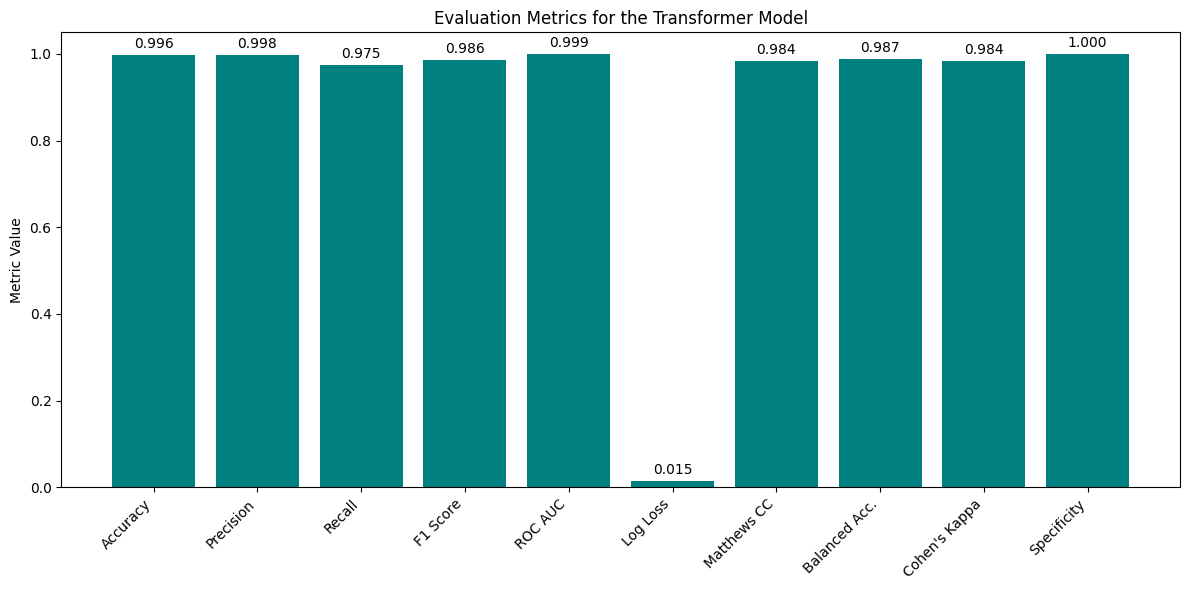

Sample 15805: Prediction: No malfunctioning
Sample 33942: Prediction: No malfunctioning
Sample 14577: Prediction: No malfunctioning
Sample 6113: Prediction: No malfunctioning
Sample 28348: Prediction: No malfunctioning
Sample 15039: Prediction: No malfunctioning
Sample 40224: Prediction: No malfunctioning
Sample 13197: Prediction: No malfunctioning
Sample 39394: Prediction: No malfunctioning
Sample 13988: Prediction: No malfunctioning
Sample 37140: Prediction: No malfunctioning
Sample 32396: Prediction: No malfunctioning
Sample 31374: Prediction: No malfunctioning
Sample 5692: Prediction: No malfunctioning
Sample 43455: Prediction: No malfunctioning
Sample 8761: Prediction: No malfunctioning
Sample 32445: Prediction: No malfunctioning
Sample 41419: Prediction: No malfunctioning
Sample 40145: Prediction: No malfunctioning
Sample 20831: DTC_NUMBER: MIL is OFF1 codes, TROUBLE_CODES: P0133 -> Prediction: Malfunctioning
Sample 30899: Prediction: No malfunctioning
Sample 21109: DTC_NUMBER: M

In [16]:
test_loss, test_accuracy = transformer_model.evaluate(X_test_processed, y_test)
print(f"Transformer Model Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_pred_proba = transformer_model.predict(X_test_processed)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
ll = log_loss(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_dict = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Log Loss": ll,
    "Matthews CC": mcc,
    "Balanced Acc.": bal_acc,
    "Cohen's Kappa": kappa,
    "Specificity": specificity
}

plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_dict.keys(), metrics_dict.values(), color='teal')
plt.title("Evaluation Metrics for the Transformer Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.3f}", xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")
plt.tight_layout()
plt.show()

predictions_df = meta_test.copy()
predictions_df['Predicted_Status'] = y_pred
predictions_df['Prediction'] = predictions_df['Predicted_Status'].apply(lambda x: "Malfunctioning" if x == 1 else "No malfunctioning")

for idx, row in predictions_df.iterrows():
    if row['Predicted_Status'] == 1:
        print(f"Sample {idx}: DTC_NUMBER: {row['DTC_NUMBER']}, TROUBLE_CODES: {row['TROUBLE_CODES']} -> Prediction: Malfunctioning")
    else:
        print(f"Sample {idx}: Prediction: No malfunctioning")